In [76]:
import numpy as np
import pandas as pd

import astropy.units as u
import astropy.constants as c
from astropy.time import Time
import datetime

In [77]:
"MATPLOTLIB"
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pylab import cm
import matplotlib.lines as lines

mpl.rcParams['font.family'] = 'Latin Modern Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 2

In [78]:
def Gain(D,freq):
    lam=c.c/(freq)
    A=np.pi*(D/2)**2
    e=1
    G=4*np.pi*e*A/lam**2 # calculate gain (Eq. A)
    return G.cgs

def power(tx,rx,df,rtdb,dl,sig=0.023*u.km**2,tau=(0.1*u.s).cgs): # from literature
    nametx=rtdb.Name[rtdb.Code==tx].iloc[0] # TX name from code
    namerx=rtdb.Name[rtdb.Code==rx].iloc[0] # RX name from code
    rtx=(df[nametx].to_numpy())*c.R_earth # distance to TX
    rrx=(df[namerx].to_numpy())*c.R_earth # distance to RX
    Dtx=rtdb.Diameter[rtdb.Code==tx].iloc[0]*u.m # TX diameter
    Drx=rtdb.Diameter[rtdb.Code==rx].iloc[0]*u.m # RX diameter
    Tsys=rtdb.Tsys[rtdb.Code==rx].iloc[0]*u.K # system temperature (RX)
    freq=rtdb.Frequency[rtdb.Code==tx].iloc[0]*1e6*u.Hz # transmission freq TX
    Ptx=rtdb.Power[rtdb.Code==tx].iloc[0]*1e3*u.W # transmission power TX
    Gtx=Gain(Dtx,freq) # TX gain
    Grx=Gain(Drx,freq) # RX gain
    Prx=(Ptx*Gtx*Grx*(c.c/(freq))**2*sig/((4*np.pi)**3*rtx**2*rrx**2)).si # calculate Prx (Eq. B)
    PrxdB=10*np.log10((Prx/u.mW).si.value)  #return Prx in dBm
    Pratio=(Prx/Ptx).si  #return TX/RX power ratio

    time=pd.to_datetime(dl.date)
    dt=(time.iloc[1]-time.iloc[0]).total_seconds()*u.s # time increment in dl
    lon=(dl.lonR.to_numpy())*u.deg.to(u.rad) # sub-radar longitude to radians
    lat=(dl.latR.to_numpy())*u.deg.to(u.rad) # sub-radar latitude to radians
    x=np.sin(lat)*np.cos(lon) # unit vector coord x
    y=np.sin(lat)*np.sin(lon) # unit vector coord y
    z=np.cos(lat) # unit vector coord z
    pointing=np.vstack((x,y,z)).T # unit vector of subradar pointing
    dtheta=np.arccos((pointing[1:]*pointing[:-1]).sum(axis=1)) # change in angle from moment to moment
    omega=dtheta/dt # angular frequency
    period=2*np.pi/omega # return rotation period
    rotfreq=1/period # rotation frequency
    phi=lat[1:] # subradar latitude
    bw=4*np.pi*np.cos(phi)*370*u.m/((c.c/freq)*period) # Doppler bandwidth (Eq. C)
    Nrms=(Tsys*c.k_B*np.sqrt(bw/tau)) # rms noise power (Eq. D)
    SNR=(Prx[1:]/Nrms).si # return signal-to-noise ratio 
    return PrxdB, Pratio, SNR, omega, nametx,namerx

In [79]:
df=pd.read_csv("../Data/observatory_distances_indexes.csv")
rtdb=pd.read_csv('../AllRadiotelescopes.csv')
dl=pd.read_csv('../Data/subradar_points.csv')
elevations = pd.read_csv("../Data/elevations.csv")

ephemeris = pd.read_csv("../ephemeris2.csv")
ephemeris['hours'] = 24*(ephemeris['datetime_jd']-ephemeris['datetime_jd'][0])
MIN = ephemeris['delta (Rt)'].argmin()

In [80]:
print([i for i in rtdb.Code])

['CDS', 'PRK', 'MDS', 'LOV', 'EFE', 'AVN', 'GOL', 'GBT', 'VLA', 'ARE', 'FAS', 'ECD', 'USU']


In [81]:
pairs = [
    ('CDS','PRK'),
    ('MDS','LOV'),
    ('MDS','AVN'),
    ('MDS','EFE'),
    ('GOL','GBT'),
    ('ARE','GBT'),
    ('ECD','FAS'),
    ('USU','FAS'),
]


'lmroman10-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


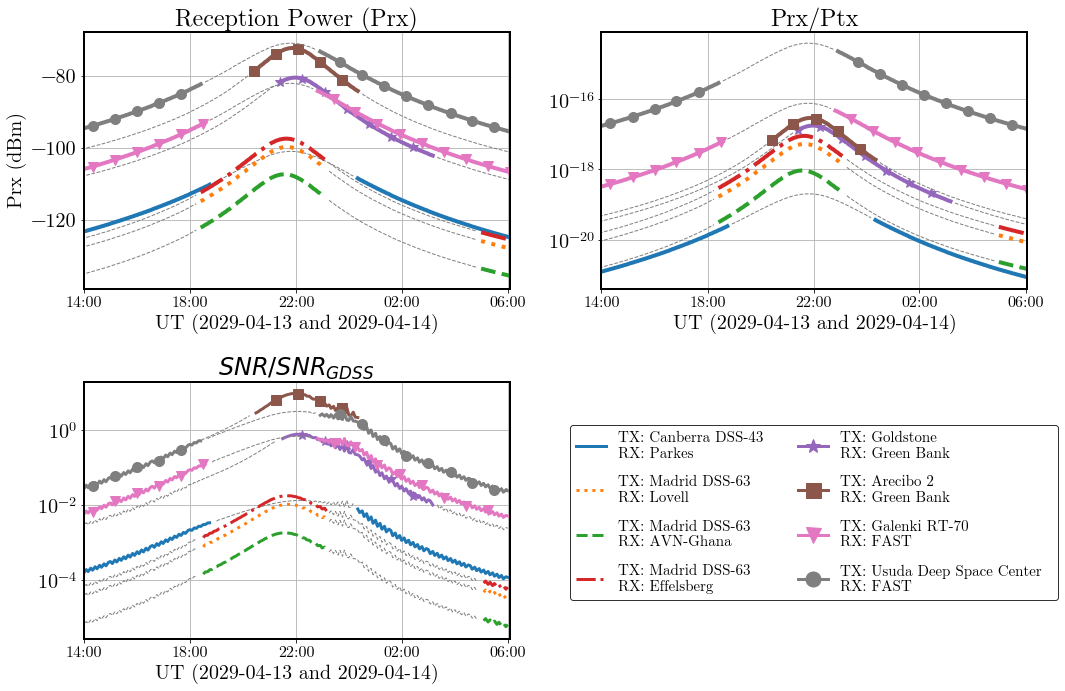

In [82]:
def x_axis(ax,i):
    ax.set_xlim([0,ephemeris['hours'].iloc[-1]])
    xticks = range(6,len(ephemeris),48)
    ax.set_xlim([ephemeris['hours'].iloc[6],ephemeris['hours'].iloc[-1]])
    ax.set_xticks([ephemeris['hours'][n] for n in xticks])

    if i != 10:
        ax.set_xticklabels([ephemeris['datetime_str'][i][-5:] for i in xticks],size=16)
        ax.set_xlabel("UT (2029-04-13 and 2029-04-14)",size=20)
    else:
        ax.set_xticklabels([])


def chop(Ys, cond):
    """
    Removes the parts of an array which correspond to non visible zones
    """
    pm = np.array([a*b for a,b in zip(elevations[tx],elevations[tx][1:])])
    nanwhere = np.where(pm < 0)
    
    Y = Ys
    Y[nanwhere] = np.nan
    Y = Y[cond]
    return Y
    

def all_power_plots(axes,n,PrxdB, Pratio, SNR, nametx,namerx,df,tx,rx):
    title='TX: {} \nRX: {}'.format(nametx,namerx)

    savefigs = False
    styles = ['-',':','--','-.','*-','s-','v-','o-','D-']

    cond = elevations[tx] > 0
    times = ephemeris['hours'][cond]
    timesnt = ephemeris['hours'][~cond]

    Y = chop(PrxdB,cond)
    Ynt = chop(PrxdB,~cond)
    
    i = 0
    ax = axes[i]
    # dBm plot
    ax.plot(times,Y,styles[n],lw=4,markevery=10,ms=10)
    ax.plot(timesnt,Ynt,'--',lw=1,color='gray')
    ax.set_title("Reception Power (Prx)")
    ax.set_ylabel("Prx (dBm)")
    x_axis(ax,i)

    Y = chop(Pratio,cond)
    Ynt = chop(Pratio,~cond)

    i += 1
    ax = axes[i]
    # Power ratio plot
    ax.semilogy(times,Y,styles[n],lw=4,markevery=10,ms=10)
    ax.semilogy(timesnt,Ynt,'--',lw=1,color='gray')
    ax.set_title("Prx/Ptx")
    x_axis(ax,i)


    Y = chop(SNR,cond[1:])
    Ynt = chop(SNR,~cond[1:])
    times = ephemeris['hours'][cond][:-1]
    timesnt = ephemeris['hours'][~cond][:-1]

    Y = Y[:min(len(Y),len(times))]
    times = times[:min(len(Y),len(times))]
    Ynt = Ynt[:min(len(Ynt),len(timesnt))]
    timesnt = timesnt[:min(len(Ynt),len(timesnt))]

    Y0 = 0.8e10

    i += 1
    ax = axes[i]
    # SNR plot
    # ax.semilogy(ephemeris['hours'][1:],SNR,styles[n],lw=3,markevery=10,ms=10)
    ax.semilogy(times,Y/Y0,styles[n],lw=3,markevery=10,ms=10)
    ax.semilogy(timesnt,Ynt/Y0,'--',lw=1,color='gray')
    ax.set_title(r"$SNR / SNR_{GDSS}$")
    x_axis(ax,i)

    i += 1
    ax = axes[i]
    # rotation period plot
    ax.plot([],[],styles[n],lw=3,markevery=10,ms=15,label=title)
    # ax.set_ylabel("Angular frequency (deg/hour)")
    # ax.legend(fontsize=15)
    x_axis(ax,i)


fig, axes = plt.subplots(2,2,figsize=(15,10))

# for ax in axes.flat:
#     ax.set_prop_cycle(plt.cycler('color', plt.cm.nipy_spectral(np.linspace(0.1,0.9,5)**2)))
# fig.suptitle("Reception (rx) and Transmission (tx) Radar Power")

n = 0
for tx, rx in pairs:
    PrxdB, Pratio, SNR, period, nametx,namerx= power(tx,rx,df,rtdb,dl)
    all_power_plots(axes.flat, n, PrxdB, Pratio, SNR, nametx, namerx, df, tx, rx)
    n += 1

for ax in axes.flat:
    ax.grid()

handles, labels = axes.flat[-1].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, bbox_to_anchor=(0.5, -0.1, 0.5, 0.5), fontsize=15, labelspacing=1, fancybox=True, edgecolor=(0,0,0))
fig.delaxes(axes.flat[-1])
# fig.delaxes(axes.flat[-3])
fig.tight_layout()

name = "../Figures/fig6_radio"
plt.savefig(name+".pdf",bbox_inches='tight')
plt.savefig(name+".png",bbox_inches='tight')

'lmroman10-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


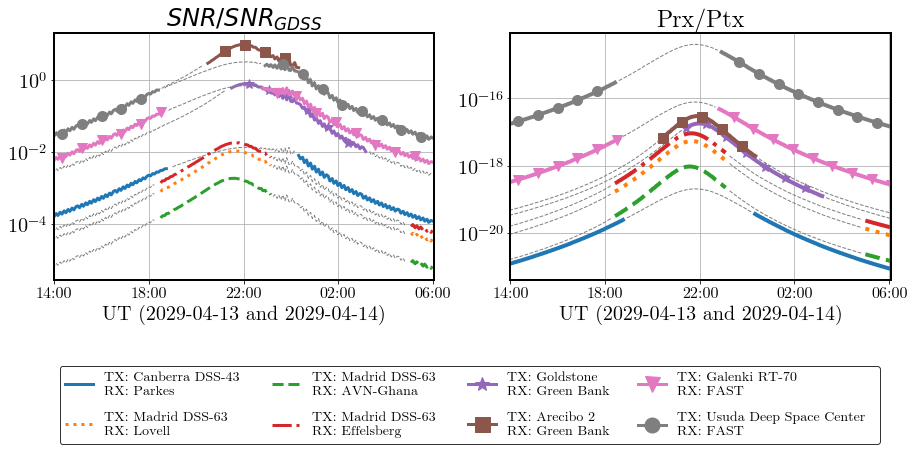

In [83]:
def x_axis(ax,i):
    ax.set_xlim([0,ephemeris['hours'].iloc[-1]])
    xticks = range(6,len(ephemeris),48)
    ax.set_xlim([ephemeris['hours'].iloc[6],ephemeris['hours'].iloc[-1]])
    ax.set_xticks([ephemeris['hours'][n] for n in xticks])

    if i != 10:
        ax.set_xticklabels([ephemeris['datetime_str'][i][-5:] for i in xticks],size=16)
        ax.set_xlabel("UT (2029-04-13 and 2029-04-14)",size=20)
    else:
        ax.set_xticklabels([])


def chop(Ys, cond):
    """
    Removes the parts of an array which correspond to non visible zones
    """
    pm = np.array([a*b for a,b in zip(elevations[tx],elevations[tx][1:])])
    nanwhere = np.where(pm < 0)
    
    Y = Ys
    Y[nanwhere] = np.nan
    Y = Y[cond]
    return Y
    

def all_power_plots(axes,n,PrxdB, Pratio, SNR, nametx,namerx,df,tx,rx):
    title='TX: {} \nRX: {}'.format(nametx,namerx)

    savefigs = False
    styles = ['-',':','--','-.','*-','s-','v-','o-','D-']

    cond = elevations[tx] > 0

    Y = chop(PrxdB,cond)
    Ynt = chop(PrxdB,~cond)
    
    i = 0
    Y = chop(SNR,cond[1:])
    Ynt = chop(SNR,~cond[1:])
    times = ephemeris['hours'][cond][:-1]
    timesnt = ephemeris['hours'][~cond][:-1]

    Y = Y[:min(len(Y),len(times))]
    times = times[:min(len(Y),len(times))]
    Ynt = Ynt[:min(len(Ynt),len(timesnt))]
    timesnt = timesnt[:min(len(Ynt),len(timesnt))]

    Y0 = 0.8e10

    ax = axes[i]
    # SNR plot
    # ax.semilogy(ephemeris['hours'][1:],SNR,styles[n],lw=3,markevery=10,ms=10)
    ax.semilogy(times,Y/Y0,styles[n],lw=3,markevery=10,ms=10)
    ax.semilogy(timesnt,Ynt/Y0,'--',lw=1,color='gray')
    ax.set_title(r"$SNR / SNR_{GDSS}$")
    x_axis(ax,i)

    Y = chop(Pratio,cond)
    Ynt = chop(Pratio,~cond)

    times = ephemeris['hours'][cond]
    timesnt = ephemeris['hours'][~cond]

    i += 1
    ax = axes[i]
    # Power ratio plot
    ax.semilogy(times,Y,styles[n],lw=4,markevery=10,ms=10)
    ax.semilogy(timesnt,Ynt,'--',lw=1,color='gray')
    ax.set_title("Prx/Ptx")
    x_axis(ax,i)

    i += 1
    ax = axes[i]
    # rotation period plot
    ax.plot([],[],styles[n],lw=3,markevery=10,ms=15,label=title)
    # ax.set_ylabel("Angular frequency (deg/hour)")
    # ax.legend(fontsize=15)
    x_axis(ax,i)

    i += 1
    ax = axes[i]
    # rotation period plot
    ax.plot([],[],styles[n],lw=3,markevery=10,ms=15,label=title)
    # ax.set_ylabel("Angular frequency (deg/hour)")
    # ax.legend(fontsize=15)
    x_axis(ax,i)


fig, axes = plt.subplots(2,2,figsize=(15,10))

# for ax in axes.flat:
#     ax.set_prop_cycle(plt.cycler('color', plt.cm.nipy_spectral(np.linspace(0.1,0.9,5)**2)))
# fig.suptitle("Reception (rx) and Transmission (tx) Radar Power")

n = 0
for tx, rx in pairs:
    PrxdB, Pratio, SNR, period, nametx,namerx= power(tx,rx,df,rtdb,dl)
    all_power_plots(axes.flat, n, PrxdB, Pratio, SNR, nametx, namerx, df, tx, rx)
    n += 1

for ax in axes.flat:
    ax.grid()

handles, labels = axes.flat[-1].get_legend_handles_labels()
fig.legend(handles, labels, ncol=4, loc = "lower center",
            fontsize=14, labelspacing=1, fancybox=True, 
            edgecolor=(0,0,0), bbox_to_anchor=(0.26, 0.3, 0.5, 0.5))
fig.delaxes(axes.flat[-1])
fig.delaxes(axes.flat[-2])
# fig.tight_layout()

name = "../Figures/fig6_radio"
plt.savefig(name+".pdf",bbox_inches='tight')
plt.savefig(name+".png",bbox_inches='tight')

# Doppler Shift

In [143]:
vectors = pd.read_csv("../Data/vectors2.csv")

In [244]:
V = (np.array((vectors.vx,vectors.vy,vectors.vz))*(u.AU/u.d)).si
R = (np.array((vectors.x,vectors.y,vectors.z))*(u.AU)).si
R1 = R/np.linalg.norm(R, axis=0)
# plt.plot(np.linalg.norm(V, axis=0))

In [280]:
# Given longitude and latitude angles in degrees, return cartesian representation
spherical = lambda lon,lat: (np.cos(np.deg2rad(lon))*np.cos(np.deg2rad(lat)),
                             np.sin(np.deg2rad(lon))*np.cos(np.deg2rad(lat)),
                             np.sin(np.deg2rad(lat)))

sphericalV = lambda lon,lat: (np.sin(np.deg2rad(lon))*np.cos(np.deg2rad(lat))*-1,
                              np.cos(np.deg2rad(lon))*np.cos(np.deg2rad(lat)),
                              0*lon)

norm = np.linalg.norm


def get_RA(TIME,LON):
  """
  Gets the longitude that will be under the asteroid at every moment
  """
  T = Time(TIME,format='jd')
  G = T.sidereal_time('apparent', 'greenwich').to(u.deg)
  return LON + G.value

import warnings
warnings.filterwarnings("ignore")

def get_dVr(obs):
    """
    Calculates the 
    """
    lon,lat = obs[['Longitude','Latitude']] # TX name from code
    RAs = get_RA(ephemeris.datetime_jd,lon)

    V_earth = (2*np.pi*c.R_earth/u.d)

    dV = (V - (sphericalV(RAs,lat)*V_earth).si)

    dVr = np.zeros((3,200))
    for i in range(200):
        dVr[:,i] = np.dot(dV[:,i],R1[:,i])
    return norm(dVr,axis=0)*(u.m/u.s)

def get_veph(code1,code2):
    """
    Calculates de Doppler Frequency Shift
    """
    obs1 = rtdb[rtdb.Code==code1].iloc[0]
    obs2 = rtdb[rtdb.Code==code2].iloc[0]

    F = obs1['Frequency']*u.MHz

    dVr1 = get_dVr(obs1)
    dVr2 = get_dVr(obs2)

    return F*dVr1*dVr2/(c.c**2)

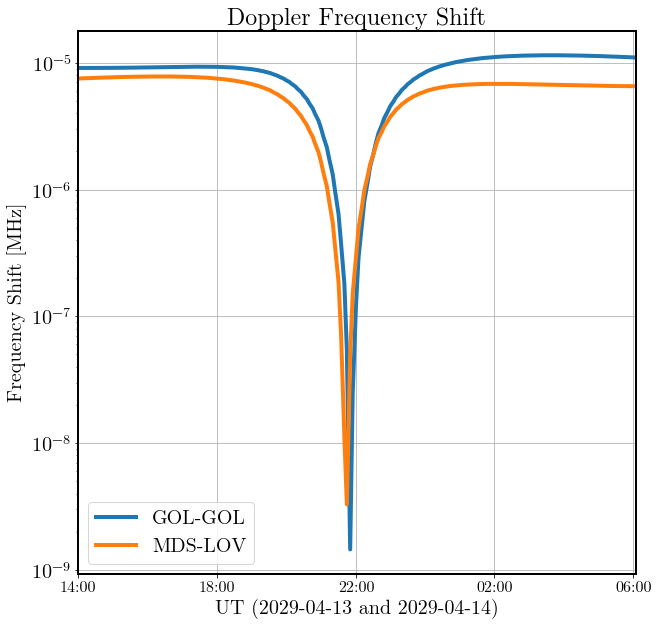

In [295]:
plt.figure(figsize=(10,10))

pairs2 = [
    ('GOL','GOL'),
    ('MDS','LOV'),
]

for pair in pairs2:
    veph = get_veph(*pair)
    plt.semilogy(ephemeris['hours'],veph,label="-".join(pair),lw=4)
x_axis(plt.gca(),0)
plt.ylabel("Frequency Shift [MHz]")
plt.title("Doppler Frequency Shift")
plt.legend()
plt.grid()

In [291]:
get_veph(*('CDS','FAS'))

<Quantity [2.95889417e-06, 2.95284328e-06, 2.94666412e-06, 2.93853338e-06,
           2.93207661e-06, 2.92362028e-06, 2.91689068e-06, 2.90811809e-06,
           2.90111999e-06, 2.89204013e-06, 2.88477725e-06, 2.87539851e-06,
           2.86787382e-06, 2.85820389e-06, 2.85041940e-06, 2.84046505e-06,
           2.83242163e-06, 2.82218844e-06, 2.81388559e-06, 2.80545489e-06,
           2.79481333e-06, 2.78611803e-06, 2.77520326e-06, 2.76623818e-06,
           2.75504952e-06, 2.74580698e-06, 2.73434115e-06, 2.72481060e-06,
           2.71306126e-06, 2.70322877e-06, 2.69118598e-06, 2.68103367e-06,
           2.66868329e-06, 2.65818865e-06, 2.64551159e-06, 2.63464674e-06,
           2.62161813e-06, 2.61034884e-06, 2.59885247e-06, 2.58522170e-06,
           2.57325392e-06, 2.55917538e-06, 2.54668099e-06, 2.53210040e-06,
           2.51901313e-06, 2.50386423e-06, 2.49010478e-06, 2.47430720e-06,
           2.45978088e-06, 2.44323758e-06, 2.42783151e-06, 2.41042572e-06,
           2.39400555e-06